In [1]:
import numpy as np
import scipy as sc
import pandas as pd
from importlib import reload

import utils

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

In [2]:
native_df = pd.read_csv('Native_allchunks_test_tpu_model.csv', index_col=0)
native_df

,sequence,measured,predicted
index,,,
0,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAAAAAAAAACTAGCA...,11.825806,11.353749
1,TGCATTTTTTTCACATCAAAAAAAAAAAAAAAATTTAAAGAATTTC...,11.412778,9.643128
2,TGCATTTTTTTCACATCAAAAAAAAGGACGTTCCACACTTGGCTGC...,10.623805,11.864820
3,TGCATTTTTTTCACATCAAAATCCGTGTAATACCAAGTCATCCTCA...,7.703389,8.650239
4,TGCATTTTTTTCACATCAGAAAAAAAGTATAATGTCAGATTTTTGT...,11.397473,13.881278
...,...,...,...
61145,TGCATTTTTTTCACATCAGAAAAAAAAAAAAAAAAAAAAAAAGAAA...,14.220082,12.520042
61146,TGCATTTTTTTCACATCAGAAAAAAAAAAAAGAGGAGACTTGAAGA...,6.978840,7.298204
61147,TGCATTTTTTTCACATCAGAAAAAAAAAAGGGATTGGGCGGTAATG...,3.917299,8.096985


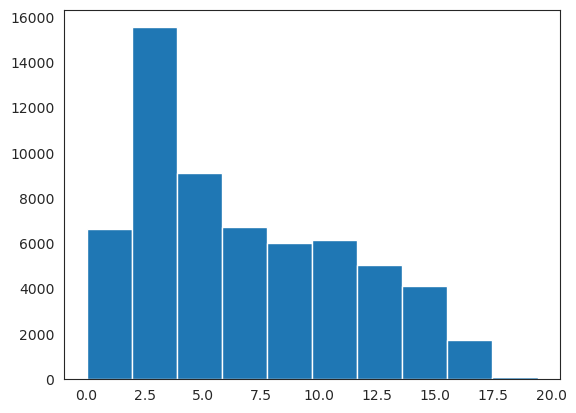

3.93575837103287 16.1135558882277


In [23]:
plt.hist(native_df.measured)
plt.show()
print(np.min(native_df.predicted), np.max(native_df.predicted))

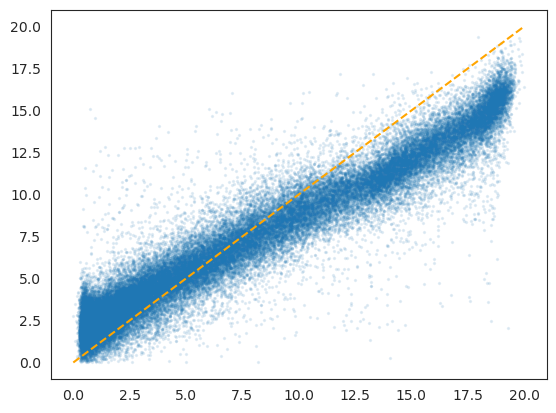

0.1638685064034364
0.9949933397740165


In [89]:
pred_N = native_df.predicted
pred_N = (pred_N - np.min(pred_N)) / (np.max(pred_N) - np.min(pred_N))
pred_N = 20* pred_N
plt.scatter(pred_N, native_df.measured, s=2, alpha=0.1)
plt.plot([0, 20], [0, 20], '--', c='orange')
plt.show()
theta_imputed = utils.get_quantile(pred_N, 0.5)
print(np.mean(utils.get_quantile_rectifier(native_df.measured, pred_N, theta_imputed)))
print(np.mean(utils.get_quantile_rectifier(native_df.measured, native_df.predicted, theta_imputed)))


5.320265880040699
0.8053475061324612


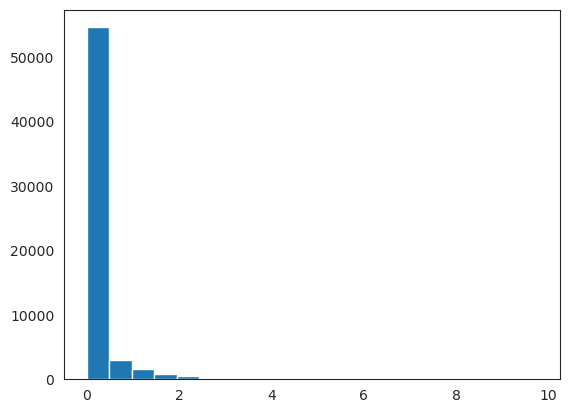

In [92]:
theta_imputed = utils.get_quantile(pred_N, 0.5)
rect_N = utils.get_quantile_rectifier(native_df.measured, pred_N, theta_imputed)
print(theta_imputed)
print(np.mean(rect_N == 0))
plt.hist(rect_N, bins=20)
plt.show()

In [71]:
from sklearn.linear_model import HuberRegressor, LinearRegression

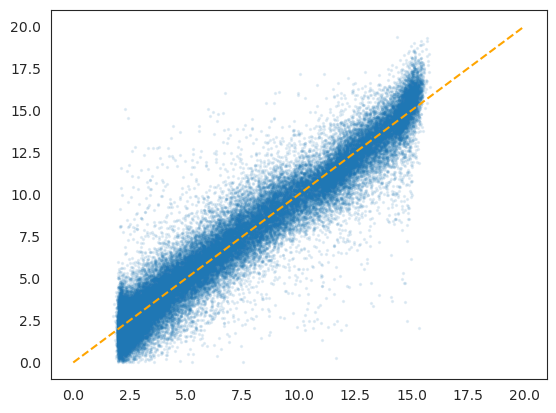

0.47156903785240745
1.0232482920874475


In [76]:
pred_N = native_df.predicted.to_numpy()
y_N = native_df.measured.to_numpy()
n_train = 1000
shuffle_idx = np.random.permutation(len(native_df))
train_idx, test_idx = shuffle_idx[: n_train], shuffle_idx[n_train :]
mod = HuberRegressor(epsilon=1)
mod.fit(pred_N[train_idx][:, None], y_N[train_idx])
predtest = mod.predict(pred_N[test_idx][:, None])
plt.scatter(predtest, y_N[test_idx], s=2, alpha=0.1)
plt.plot([0, 20], [0, 20], '--', c='orange')
plt.show()
theta_imputed = utils.get_quantile(predtest, 0.5)
print(np.mean(utils.get_quantile_rectifier(y_N[test_idx], predtest, theta_imputed)))
print(np.mean(utils.get_quantile_rectifier(native_df.measured, native_df.predicted, theta_imputed)))


In [87]:
# compare classical and PP CIs
reload(utils);
ns = np.array([10, 20, 40, 80, 160])
N = 40000
ymin = 0
ymax = 20
B = ymax
q = 0.5
n_trial = 10
alpha = 0.1
delta1 = 0.02 # root-n term
delta2 = 0.07   # hoeffding

pred_all = (pred_all - np.min(pred_all)) / (np.max(pred_all) - np.min(pred_all))
pred_all = 21 * pred_all
res_n = pred_all - native_df.measured.to_numpy()
pred_all = native_df.measured.to_numpy() + 0.9 * res_n

cilen_nxtx3 = np.zeros([ns.size, n_trial, 3])
for n_idx, n in enumerate(ns):
    for t in range(n_trial):
        
        lab_idx = np.random.choice(len(native_df), n, replace=True) 
        y_n = native_df.measured[lab_idx].to_numpy()
        f_n = pred_all[lab_idx]
        unlab_idx = np.random.choice(len(native_df), N, replace=True)
        y_N = native_df.measured[unlab_idx].to_numpy()
        f_N = pred_all[unlab_idx]
        
        ci_pp, ci_ideal_pp, rectl_ub, rectu_ub, hoeffding_ub = utils.get_pp_ci(
            y_n, y_N, f_n, f_N, q, alpha, delta1, delta2, B, ymin, ymax)
        # print(rectl_ub, rectu_ub, hoeffding_ub)
        
        ci_cl, _, _ = utils.get_classical_ci(y_n, q, alpha, ymin, ymax)
        cilen_nxtx3[n_idx, t] = ci_pp[1] - ci_pp[0], ci_ideal_pp[1] - ci_ideal_pp[0], ci_cl[1] - ci_cl[0]
    print('done with {}'.format(n))

done with 10
done with 20
done with 40
done with 80
done with 160


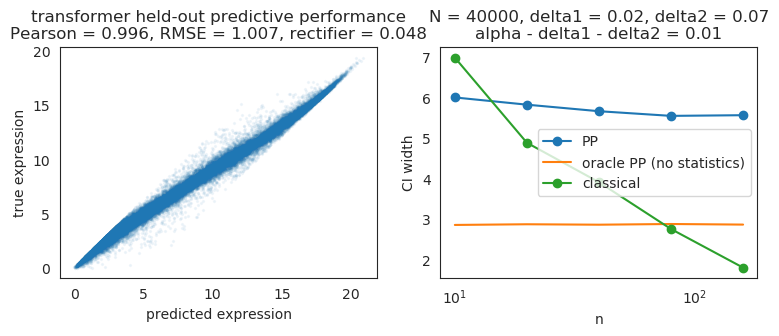

In [88]:
plt.figure(figsize=(9, 3))

r, p = sc.stats.pearsonr(pred_all, native_df.measured)
rmse = np.sqrt(np.mean(np.square(pred_all - native_df.measured)))
theta_imputed = utils.get_quantile(pred_all, 0.5)
rect = np.mean(utils.get_quantile_rectifier(native_df.measured, pred_all, theta_imputed))
plt.subplot(121)
plt.scatter(pred_all, native_df.measured, s=2, alpha=0.05)
plt.xlabel('predicted expression'); plt.ylabel('true expression');
plt.title('transformer held-out predictive performance\nPearson = {:.3f}, RMSE = {:.3f}, rectifier = {:.3f}'.format(
    r, rmse, rect
))
plt.subplot(122)
plt.plot(ns, np.mean(cilen_nxtx3[:, :, 0], axis=1), '-o', label='PP')
plt.plot(ns, np.mean(cilen_nxtx3[:, :, 1], axis=1), '-', label='oracle PP (no statistics)')
plt.plot(ns, np.mean(cilen_nxtx3[:, :, 2], axis=1), '-o', label='classical')
plt.xscale('log')
plt.xlabel('n');
plt.ylabel('CI width');
plt.legend();
plt.title('N = {}, delta1 = {}, delta2 = {}\nalpha - delta1 - delta2 = {:.2f}'.format(N, delta1, delta2, alpha - delta1 - delta2))
plt.show()